In [1]:
from prod import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
seed_val = 0

### Configure Training and Test Set

In [2]:
DF = pd.read_csv('../../data_preparation/output/total_compounds.csv')
DF['active'] = [0 if x==0 else 1 for x in DF['read_count']]

In [4]:
train, test = train_test_split_by_compound(DF, frac=0.90, seed=0)

In [5]:
train_bb1 = unique_bb(train, bb_pos='bb1')
train_bb2 = unique_bb(train, bb_pos='bb2')
train_bb3 = unique_bb(train, bb_pos='bb3')

test_bb1 = unique_bb(test, bb_pos='bb1')
test_bb2 = unique_bb(test, bb_pos='bb2')
test_bb3 = unique_bb(test, bb_pos='bb3')

In [6]:
# Check that all building blocks in the test set are also in the training set
print(len(set(test_bb1) - set(train_bb1)))
print(len(set(test_bb2) - set(train_bb2)))
print(len(set(test_bb3) - set(train_bb3)))

0
0
0


In [7]:
# Generate dataframe of building blocks and their P(active) value for each position
bb1_train = pd.DataFrame(train_bb1, columns=['bb1'])
bb2_train = pd.DataFrame(train_bb2, columns=['bb2'])
bb3_train = pd.DataFrame(train_bb3, columns=['bb3'])

bb1_train = calc_pactive(train, bb1_train, bb_pos='bb1')
bb2_train = calc_pactive(train, bb2_train, bb_pos='bb2')
bb3_train = calc_pactive(train, bb3_train, bb_pos='bb3')

In [8]:
# Load in reference dataframe with order of building blocks used to calculate similarity matrix
bb1_ref = pd.read_csv('../../data_preparation/output/bb1_list.csv').reset_index()
bb2_ref = pd.read_csv('../../data_preparation/output/bb2_list.csv').reset_index()
bb3_ref = pd.read_csv('../../data_preparation/output/bb3_list.csv').reset_index()

In [9]:
# Align indices of training set building blocks with the reference list
bb1_train_ind = match(bb1_train, bb1_ref, bb_pos='bb1')
bb2_train_ind = match(bb2_train, bb2_ref, bb_pos='bb2')
bb3_train_ind = match(bb3_train, bb3_ref, bb_pos='bb3')

### Transform similarity scores into UMAP distances

In [10]:
# Calculate 2D UMAP coordinates for each building block
bb1_sim_3D = np.load('../../similarity_calculation/output/bb1_list.npy')
bb2_sim_3D = np.load('../../similarity_calculation/output/bb2_list.npy')
bb3_sim_3D = np.load('../../similarity_calculation/output/bb3_list.npy')

bb1_dist = dist_mat(bb1_sim_3D)
bb2_dist = dist_mat(bb2_sim_3D)
bb3_dist = dist_mat(bb3_sim_3D)

bb1_coords, bb1_umap = UMAP_dist(bb1_dist[np.ix_(bb1_train_ind, bb1_train_ind)], seed=seed_val)
bb2_coords, bb2_umap = UMAP_dist(bb2_dist[np.ix_(bb2_train_ind, bb2_train_ind)], seed=seed_val)
bb3_coords, bb3_umap = UMAP_dist(bb3_dist[np.ix_(bb3_train_ind, bb3_train_ind)], seed=seed_val)

,Position,top - top dist,top - rand dist
0,1,3.770177,6.466061
1,2,1.092371,4.703093
2,3,4.030662,8.199737


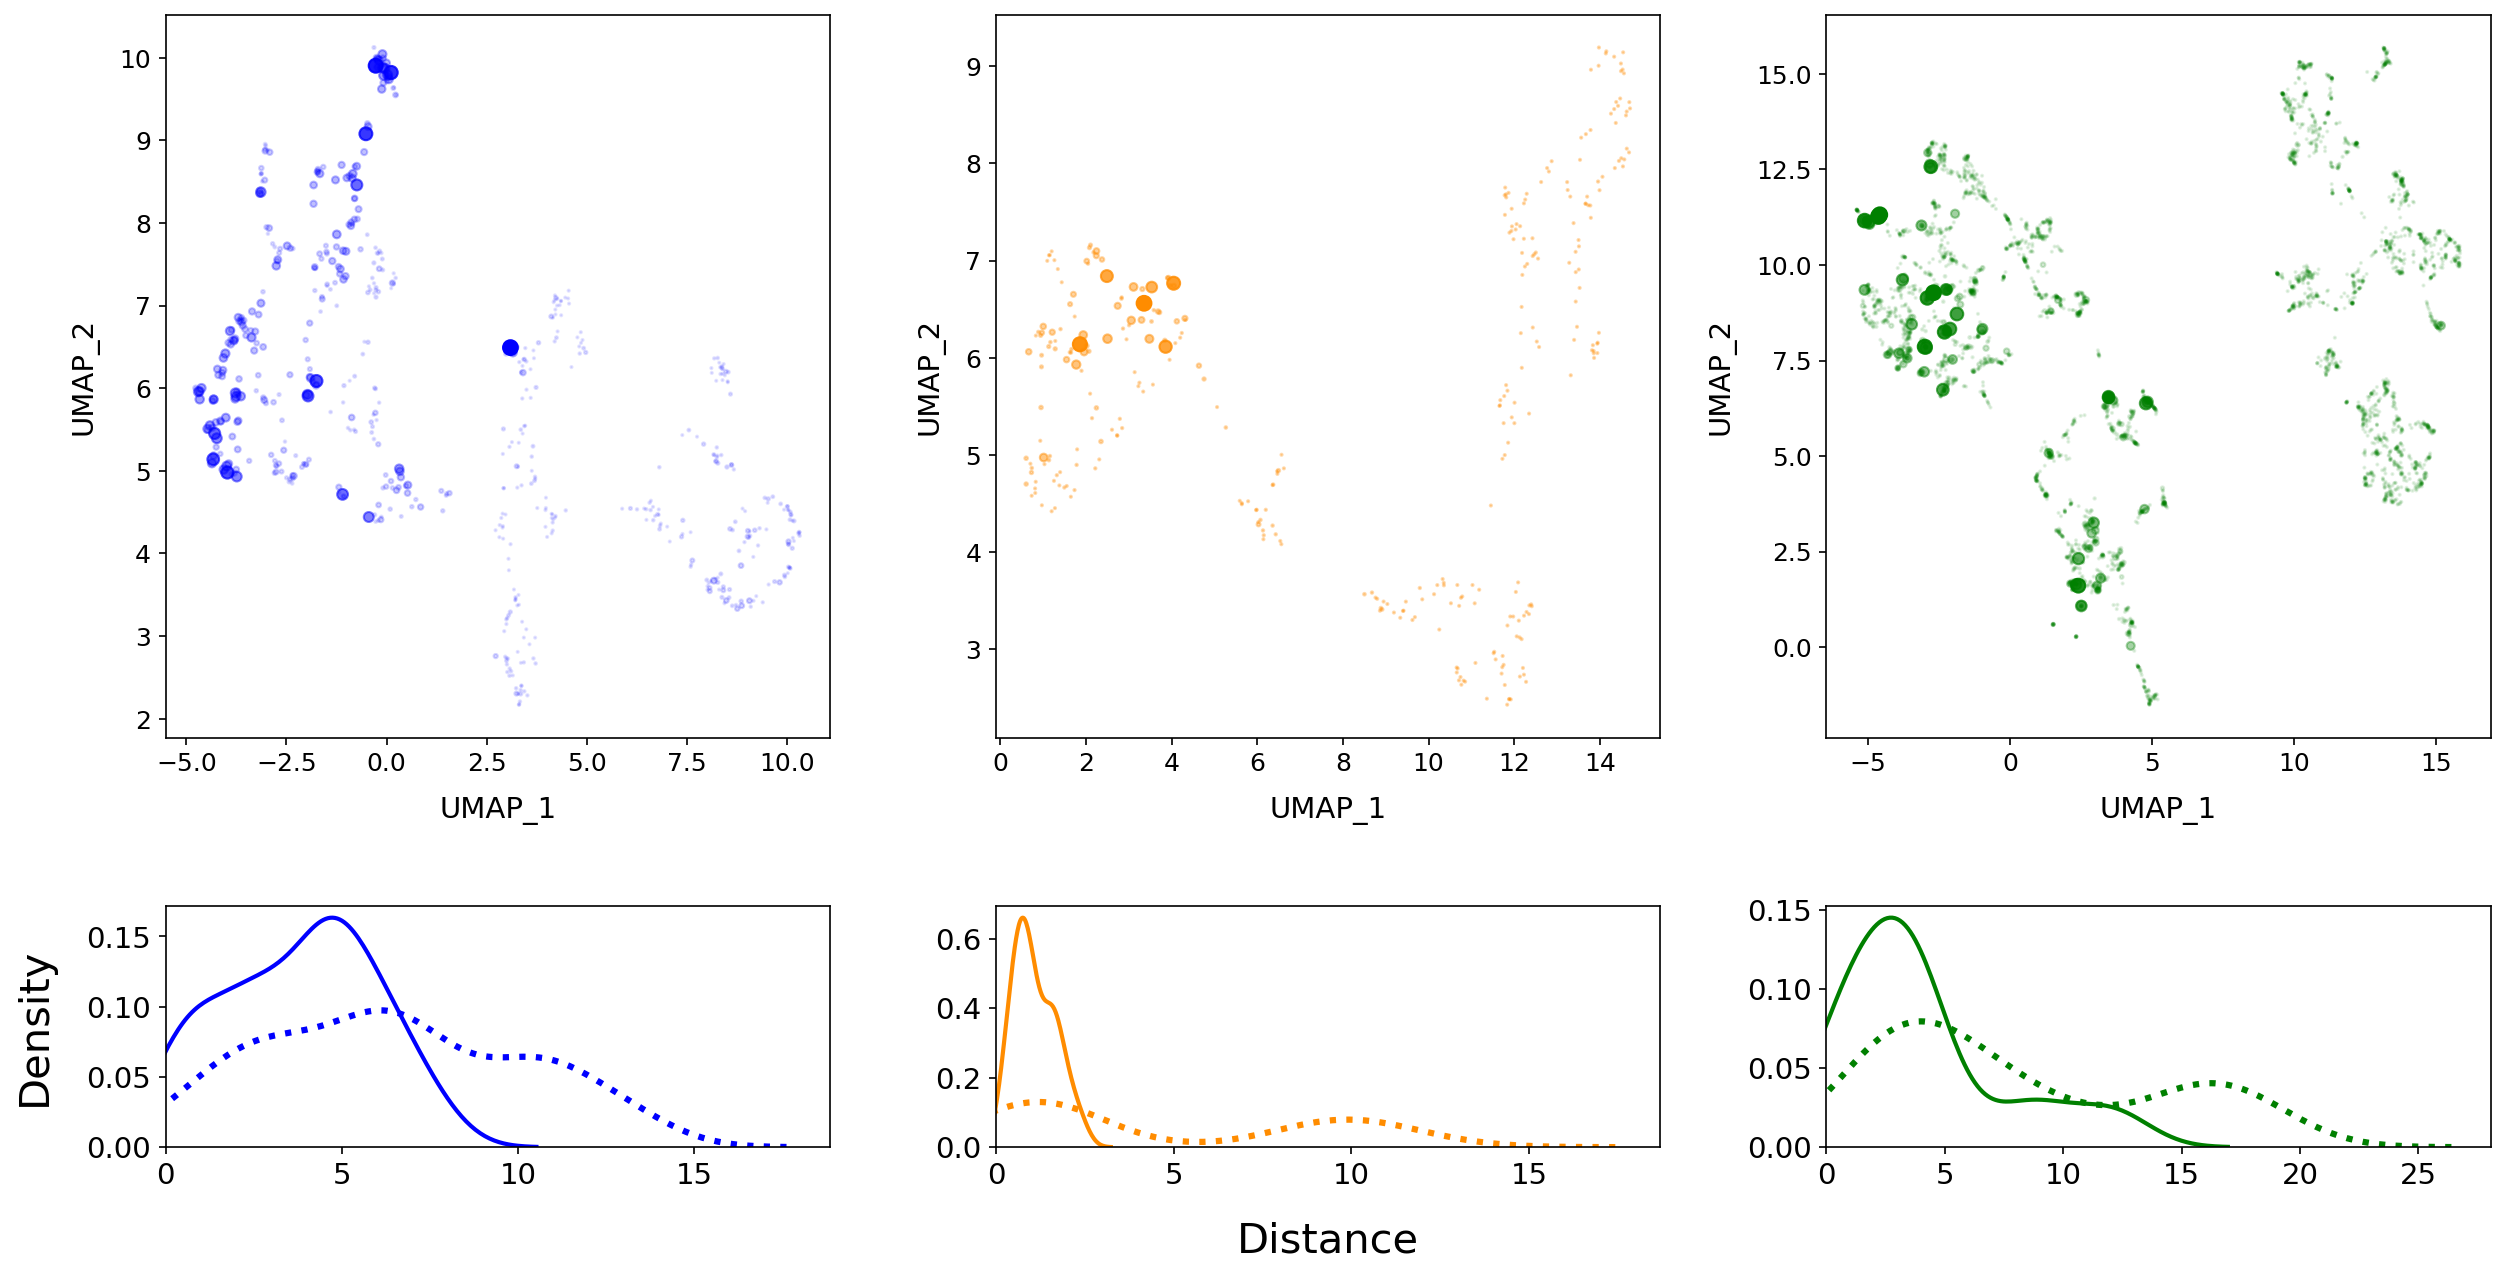

In [11]:
bb1_train, bb2_train, bb3_train = plot_umap(bb1_train, bb2_train, bb3_train, bb1_umap, bb2_umap, bb3_umap)

In [12]:
bb1_train = assign_coords(bb1_train, bb1_coords)
bb2_train = assign_coords(bb2_train, bb2_coords)
bb3_train = assign_coords(bb3_train, bb3_coords)

### Determine optimal HDBSCAN hyperparameters

In [13]:
opt_params_bb1 = optimal_hdbscan(bb1_train)
opt_params_bb2 = optimal_hdbscan(bb2_train)
opt_params_bb3 = optimal_hdbscan(bb3_train)

In [14]:
bb1_clusterer, bb1_cluster_labels = cluster(bb1_train, opt_params_bb1)
bb2_clusterer, bb2_cluster_labels = cluster(bb2_train, opt_params_bb2)
bb3_clusterer, bb3_cluster_labels = cluster(bb3_train, opt_params_bb3)

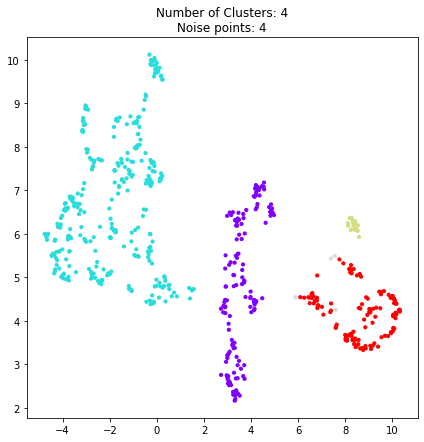

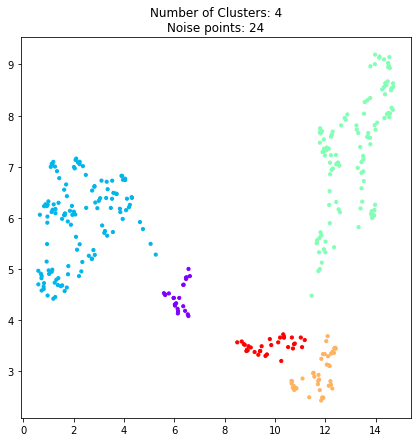

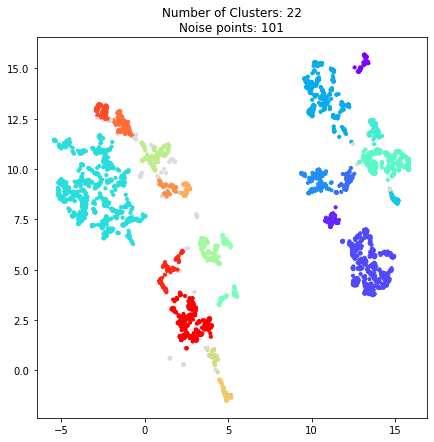

In [15]:
bb1_train = plot_hdbscan(bb1_train, opt_params_bb1, bb1_umap)
bb2_train = plot_hdbscan(bb2_train, opt_params_bb2, bb2_umap)
bb3_train = plot_hdbscan(bb3_train, opt_params_bb3, bb3_umap)

### Estimate P(active) of test set building blocks

### Create decision tree

In [19]:
train_input = format_data_for_tree(train, bb1_train, bb2_train, bb3_train)
train_features = train_input[['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster', 'P(active)_1', 'P(active)_2', 'P(active)_3']]
train_targets = train_input['active'].to_numpy()

In [21]:
train_precision, cv_precision = cv_trees(X=train_features, y=train_targets, k_fold=5, tree_depths=range(1,9), scoring='precision')
train_recall, cv_recall = cv_trees(X=train_features, y=train_targets, k_fold=5, tree_depths=range(1,9), scoring='recall')

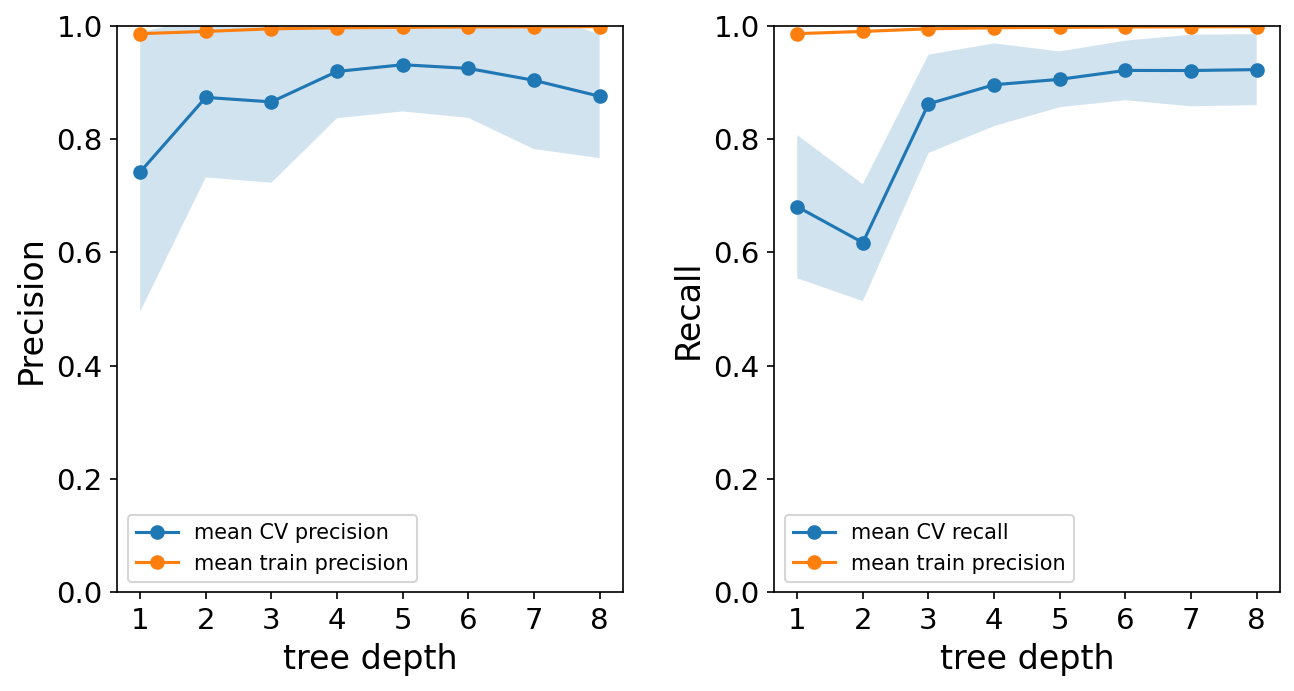

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), dpi=150)
plt.subplots_adjust(wspace=0.3)
tree_depths = range(1,9)
axs[0].plot(tree_depths, cv_precision[:, 0], '-o', label='mean CV precision')
axs[0].fill_between(tree_depths, cv_precision[:, 0]-cv_precision[:,1], cv_precision[:, 0]+cv_precision[:,1], alpha=0.2)
axs[0].plot(tree_depths, train_precision, '-o', label='mean train precision')
axs[0].legend(loc='best')
axs[0].set_xticks(tree_depths)
axs[0].tick_params(labelsize=14)
axs[0].set_xlabel('tree depth', fontsize=16)
axs[0].set_ylabel('Precision', fontsize=16)
axs[0].set_ylim([0, 1.0])

axs[1].plot(tree_depths, cv_recall[:, 0], '-o', label='mean CV recall')
axs[1].fill_between(tree_depths, cv_recall[:, 0]-cv_recall[:,1], cv_recall[:, 0]+cv_recall[:,1], alpha=0.2)
axs[1].plot(tree_depths, train_recall, '-o', label='mean train precision')
axs[1].legend(loc='best')
axs[1].set_xticks(tree_depths)
axs[1].tick_params(labelsize=14)
axs[1].set_xlabel('tree depth', fontsize=16)
axs[1].set_ylabel('Recall', fontsize=16)
axs[1].set_ylim([0, 1.0])
#fig.savefig('SI_figure_6.png')
plt.show()

In [23]:
train_input = format_data_for_tree(train, bb1_train, bb2_train, bb3_train)
tree_classifier = create_tree(train_input, seed=seed_val, depth=5)

In [24]:
# Initialize tree with optimal depth determined through cross-validation
fig, axs = plt.subplots(figsize=(80, 50), dpi=150)
feature_names = ['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster',
                 'P(active)_1', 'P(active)_2', 'P(active)_3']
class_names = ['active', 'ina']
tree.plot_tree(tree_classifier, feature_names=feature_names, filled=True, ax=axs, fontsize=40,
              impurity=False, rounded=True)
#fig.savefig('decision_tree.svg')
plt.show()

In [26]:
test_input = format_data_for_tree(test, bb1_train, bb2_train, bb3_train)
test_input['active'] = [0 if x == 0 else 1 for x in test_input['read_count']]
test_features = test_input[['bb1_Cluster', 'bb2_Cluster', 'bb3_Cluster', 'P(active)_1', 'P(active)_2', 'P(active)_3']]

Test precision: 0.963
Test recall: 0.916


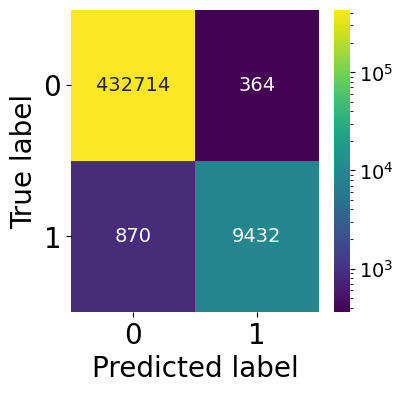

In [27]:
# Visualize confusion matrix of test set results
test_pred = tree_classifier.predict(test_features)
cm = confusion_matrix(test_input['active'], test_pred)

from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(figsize=(4,4), dpi=100)

sns.heatmap(cm, norm=LogNorm(), annot=True, fmt='d', annot_kws={'fontsize': 14}, cmap='viridis', ax=axs)
axs.tick_params(labelsize=20, rotation=0)
axs.set_xlabel('Predicted label', fontsize=20)
axs.set_ylabel('True label', fontsize=20)
cax = axs.figure.axes[-1]
cax.tick_params(labelsize=14)

print(f"Test precision: {precision_score(test_input['active'], test_pred):.3f}")
print(f"Test recall: {recall_score(test_input['active'], test_pred):.3f}")

0.9618448293743741


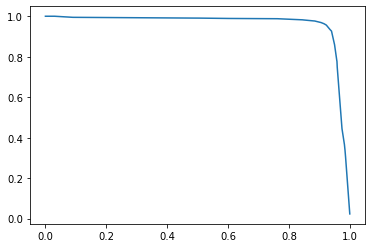

In [36]:
# Generate AUC curve prediction
test_prob = predict_activity(test_input, tree_classifier)
val = calculate_auc(test_input['active'], test_prob)
print(val)
p,r,t = precision_recall_curve(test_input['active'], test_prob)
plt.plot(r,p)